## Proyect 1 Understanding calibration in CNNs

Students
*Álex Sánchez Zurita*
*Jorge Barcenilla Gonzalez*
*Santiago Prieto Núñez*

In this lab, you will investigate the calibration convolutional CNNs in a classification setting:
- Read the paper "On calibration on modern neural networks," particularly sections 1 to 4

- Train a Lenet5 CNN from scratch to classify birds from cats in CIFAR10. Namely, we only consider two categories. Evaluate the reliability diagram and the ECE in the test set. You have methods for this in sklearn.

- Implement a basic temperature scaling (Platt's scaling), where the output probability $p(zi)$ (being zi the logit) is modified by $p(az_i)$, where a is a **constant chosen to smooth the output probabilities**. Study the effect of parameter 
a- Plot the reliability diagram and the ECE after applying the scaling.

- (Optional, adds 0.25 additional points to the project grade) - Repeat the same experiment for a much bigger model obtained after fine-tuning a pre-trained model's last classification layer. Note that if you use a model pre-trained over a different database, you probably have to re-adapt the input dimensionality.

In [239]:
import os
import torch
import time
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as optimize
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss
import pandas as pd

## 1 Analize the dataset


Number of images per class:
Train: {'bird': 5000, 'cat': 5000}
Test:  {'bird': 1000, 'cat': 1000}


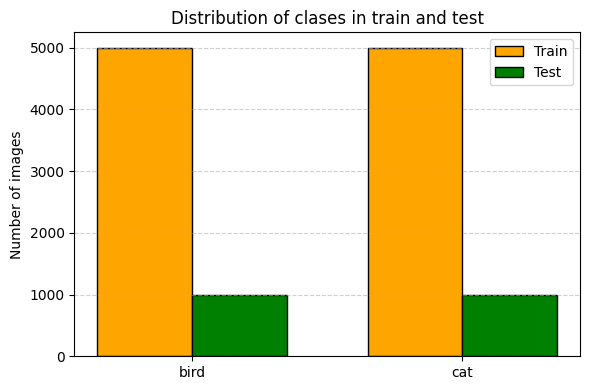

In [240]:
# Model and dataset variables
DATA_DIR = './data'
BATCH_SIZE = 32
NUM_EPOCH = 10
CV_PARAMS = False       # get the best params for train tools
DROPOUT=0.4             # dropout 40%


# Transform the data to tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 1-- Load the folders with the datsets
train_dataset = datasets.ImageFolder(root=os.path.join(DATA_DIR, 'train'), transform=transform)
test_dataset = datasets.ImageFolder(root=os.path.join(DATA_DIR, 'test'), transform=transform)
classes = train_dataset.classes

# Count the imáges of each class
def count_images(dataset):
    counts = {cls: 0 for cls in classes}
    for _, label in dataset:
        counts[classes[label]] += 1
    return counts

train_counts = count_images(train_dataset)
test_counts = count_images(test_dataset)

print("\nNumber of images per class:")
print(f"Train: {train_counts}")
print(f"Test:  {test_counts}")

# 2-- Plot the clases proportions
fig, ax = plt.subplots(figsize=(6,4))
x = np.arange(len(classes))
width = 0.35

ax.bar(x - width/2, list(train_counts.values()), width, label='Train', color='orange', edgecolor='black')
ax.bar(x + width/2, list(test_counts.values()), width, label='Test', color='green', edgecolor='black')

ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.set_ylabel('Number of images')
ax.set_title('Distribution of clases in train and test')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

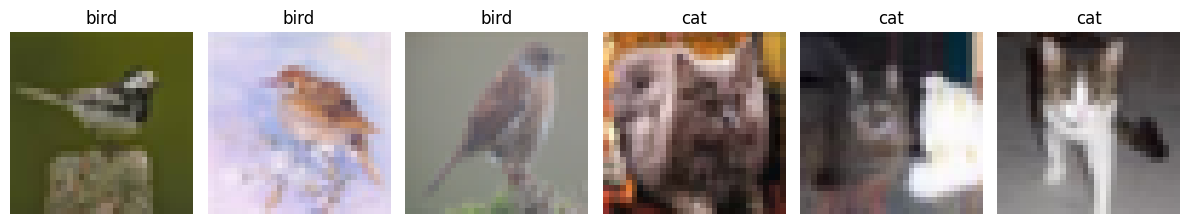

In [241]:
import random
from PIL import Image

# Show a sample of the images of the datset with his class
def show_images_from_dirs(base_dir, classes, n_images=4):
    img_paths = []
    labels = []

    # get the image paths
    for cls in classes:
        class_dir = os.path.join(base_dir, cls)
        all_images = os.listdir(class_dir)

        # get a random sample of images
        selected_images = random.sample(all_images, min(int(n_images/len(classes)), len(all_images)))
        for img_name in selected_images:
            img_paths.append(os.path.join(class_dir, img_name))
            labels.append(cls)

    n_images = len(img_paths)
    plt.figure(figsize=(2 * n_images, 4))

    for i, path in enumerate(img_paths):
        img = Image.open(path)  # abrir imagen
        plt.subplot(1, n_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(labels[i])

    plt.tight_layout()
    plt.show()

base_dir = './data/train'
classes = ['bird', 'cat']
show_images_from_dirs(base_dir, classes, n_images=6)

Finally we must change the classes from "bird" and "cat" to 0 and 1 to classify

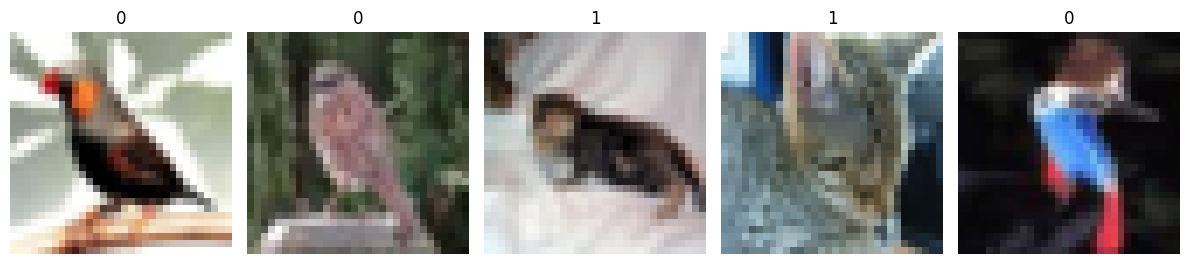

In [242]:
# filter dataset clases
train_dataset.targets = [0 if t==2 else 1 for t in train_dataset.targets]
test_dataset.targets = [0 if t==2 else 1 for t in test_dataset.targets]

# show 5 random images with its new class
indices = random.sample(range(len(train_dataset)), 5)

plt.figure(figsize=(12, 3))
for i, idx in enumerate(indices):
    img, label = train_dataset[idx]
    img = img / 2 + 0.5  # convert orig from [-1,1] to [0,1]
    npimg = img.numpy()
    
    plt.subplot(1, 5, i+1)
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.axis('off')
    plt.title(label)  # show label

plt.tight_layout()
plt.show()


## 2 Model definition

We can make the model following the original arquitecture of *Yann LeCun* in 
["GradientBased Learning Applied to Document Recognition"](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf).
In the pag 7 we can follow a detailed descripiton of each layer component.
This arquitecture is outdated so we tryed to create a model similar to the 
original with some modern technniques to improve the accuracy and optimize the 
train time.

### 2.1 ECE

One commonly used metric is the `expected_calibration_error` function, which measures how well the predicted probabilities of a classification model are calibrated. It compares the model’s **average confidence** with its **actual accuracy** across different probability bins.  

A **low ECE** indicates that the model is well-calibrated (its predicted probabilities match the true frequency of correct predictions).  
This metric is useful for evaluating probabilistic models such as neural networks or logistic regression classifiers.  


In [243]:
def expected_calibration_error(y_true, y_prob, n_bins=10):
    """
    Calculate Expected Calibration Error (ECE)
    Attributes
        - y_true : True class labels
        - y_prob : Predicted probabilities
        - n_bins : Number of confidence bins between 0 and 1

    Returns
        - ece : Expected Calibration Error (lower is better)
    """
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    ece = 0
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        # Find samples in this confidence bin
        in_bin = (y_prob > bin_lower) & (y_prob <= bin_upper)
        prop_in_bin = in_bin.mean()
        
        if prop_in_bin > 0:
            # Average confidence in this bin
            confidence_in_bin = y_prob[in_bin].mean()
            # Average accuracy in this bin
            accuracy_in_bin = y_true[in_bin].mean()
            # Add to ECE
            ece += np.abs(accuracy_in_bin - confidence_in_bin) * prop_in_bin
    
    return ece

### 2.1 The LeNet5 Architecture

This modernized LeNet5 architecture includes the following improvements:

### Key Changes:
1. **MaxPooling instead of Subsampling**: Replaced trainable subsampling layers with standard MaxPooling layers (2x2, stride=2)
2. **Batch Normalization**: Added BatchNorm2d layers after each convolution for better training stability
3. **Increased Filter Sizes**: More filters per layer (32→64→128 instead of 6→16→120)
4. **Dropout Regularization**: Added dropout layers (p=0.5) in the classifier to prevent overfitting
5. **ReLU Activations**: Using ReLU instead of sigmoid/tanh for better gradient flow
6. **Proper Weight Initialization**: Kaiming normal initialization for conv layers, appropriate for ReLU activations
7. **Adam Optimizer**: Using Adam optimizer instead of SGD for better convergence

### Architecture Details:
- **Input**: 3x32x32 (CIFAR-10 RGB images)  
- **Conv1**: 32 filters, 5x5 kernel, padding=2 → BatchNorm → ReLU → MaxPool(2x2)
- **Conv2**: 64 filters, 5x5 kernel, padding=2 → BatchNorm → ReLU → MaxPool(2x2)  
- **Conv3**: 128 filters, 3x3 kernel, padding=1 → BatchNorm → ReLU → MaxPool(2x2)
- **Classifier**: Dropout → FC(2048→512) → ReLU → Dropout → FC(512→128) → ReLU → FC(128→2)

This modern architecture should provide better performance and faster convergence compared to the original LeNet5

In [244]:
# Modern LeNet5 with MaxPooling and improved architecture
class Lenet5(nn.Module):
    def __init__(self, nlabels=10, dropout=False):
        super().__init__()
        # C1: Conv 5x5, 6 filters
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        # C3: Conv 5x5, 16 filters
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        # S2 and S4. Max pool layer instead of the original subsampling
        self.pool = nn.MaxPool2d(2, 2)
        
        # final dimension of the Convolutional phase
        self.c_final_dim = 16*5*5      # 16 num filters 5x5 kernel sizes
    
        # C5 is originally a Conv layer, but since input is 32x32 is as a linear
        self.linear1 = nn.Linear(self.c_final_dim,120)   
        self.linear2 = nn.Linear(120,84)
        self.linear3 = nn.Linear(84,nlabels)
    
        # activation function for the hidden layers
        self.relu = nn.ReLU()
        
        # final classification output activation function
        self.logsoftmax = nn.LogSoftmax(dim=1)

        # add dropout if need with a 20%
        if dropout:
            self.dropout = nn.Dropout(p=0.2) 
        

        
    def forward(self, x):
        # Pass the input through the Convolution layers
        x = self.conv1(x)
        x = self.relu(x) 
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        # Flatten the tensor into a vector of appropiate dimension using self.final_dim
        x = x.view(x.size(0), -1)
        # Pass the tensor through the MLP layers
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.logsoftmax(x)  # get the softmax output
        return x
    
    # Initialization is made with a gaussian distribution to get better convergency
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [245]:
class Lenet5_model(Lenet5):
    """
    A wrap over the LeNet5 class to add the train and evaluation
    functionalities
    """
    
    def __init__(self, dropout=False, nlabels=10, epochs=50, lr=0.001):
        """
        Initialization function for wrap
        Attributes:
            nlabels: number of classification labels
            epoch: train epochs
            lr: learing rate for optimizer
        """
        
        super().__init__(nlabels, dropout)  
        
        self.lr = lr
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs

        # define the device used
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)
        print("📦 Using device:", self.device)
        
        self.loss_fn = nn.CrossEntropyLoss()

        # Temperature parámeter (T) start 1 = not calibrate
        self.temperature = 1.0
        self.val_logits = []
        self.val_labels = []

        # Evaluation metrics  
        self.loss_train = []        # Loss
        self.loss_validation = []    
        self.loss_test = 0

        self.acc_train = []         # Accuracy
        self.acc_validation = []
        self.acc_test = 0

        self.ece_train = []         # ECE
        self.ece_validation = []
        self.ece_test = 0
    
        
    def trainloop(self, train_loader: DataLoader, valid_loader: DataLoader):

        print("📊 Training on %d samples, validating on %d samples"
              %(len(train_loader.dataset), len(valid_loader.dataset)))

        for e in range(int(self.epochs)):
            start_time = time.time()
            running_loss = 0            # acumulated loss of epoch
            total_correct = 0           # correct classifier counter
            total_samples = 0

            all_train_probs = []        # ECE data
            all_train_correct = []

            self.train()    # Set model to train
            for inputs, labels in train_loader:
                # Move batch to GPU
                if self.device.type == "cuda":
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)

                self.optim.zero_grad()      # reset optim gradients

                # Forward step
                outputs = self.forward(inputs)
                loss = self.loss_fn(outputs,labels)
                
                # Backward step
                loss.backward()
                self.optim.step()

                # Save the loss value
                running_loss += loss.item()

                # Get the accuracy
                probs = F.softmax(outputs, dim=1)
                conf, predicted = torch.max(probs, 1)
                total_samples += labels.size(0)
                total_correct += (predicted == labels).sum().item()

                # ECE data
                all_train_probs.extend(conf.detach().cpu().numpy())
                all_train_correct.extend((predicted == labels).detach().cpu().numpy())
                 
            self.loss_train.append(running_loss/len(train_loader.dataset))
            self.acc_train.append(total_correct / total_samples)

            self.ece_train.append(expected_calibration_error(
                np.array(all_train_correct),
                np.array(all_train_probs),
                n_bins=15
            ))

            # For GPU eficency
            if self.device.type == "cuda":
                torch.cuda.empty_cache()
            
            # -- Validtion step 
            with torch.no_grad():       # Deactivate the gradients
                self.eval()             # validation mode
                running_loss = 0
                total_correct = 0 
                total_samples = 0

                all_val_probs = []        # ECE data
                all_val_correct = []
                
                for inputs, labels in valid_loader:
                    # Move batch to GPU
                    if self.device.type == "cuda":
                        inputs = inputs.to(self.device)
                        labels = labels.to(self.device)
                    
                    # Forward step
                    outputs = self.forward(inputs)

                    # Get loss value
                    loss = self.loss_fn(outputs,labels) # YOU CODE HERE

                    # Save loss value
                    running_loss += loss.item()

                    # Save the validation prediction for calibration
                    if e == self.epochs-1:
                        self.val_logits.append(outputs.detach().cpu())
                        self.val_labels.append(labels.detach().cpu())

                    # Get the accuracy
                    probs = F.softmax(outputs, dim=1)
                    conf, predicted = torch.max(probs, 1)
                    total_samples += labels.size(0)
                    total_correct += (predicted == labels).sum().item()

                    # ECE data
                    all_val_probs.extend(conf.detach().cpu().numpy())
                    all_val_correct.extend((predicted == labels).detach().cpu().numpy())

            # save the results of validation
            self.loss_validation.append(running_loss/len(valid_loader.dataset))
            self.acc_validation.append(total_correct / total_samples)

            self.ece_validation.append(expected_calibration_error(
                np.array(all_val_correct),
                np.array(all_val_probs),
                n_bins=15
            ))

            print("Epoch %d. Training loss %.3f, acc: %.3f, ECE: %.3f\tValidation loss: %.3f, acc: %.3f, ECE: %.3f\tTime of epoch: %.3f seconds" 
                    %(e, self.loss_train[-1],self.acc_train[-1], self.ece_train[-1],
                    self.loss_validation[-1],self.acc_validation[-1], self.ece_validation[-1],
                    (time.time() - start_time)))
            
    
    def test_model(self, test_loader: DataLoader):
        """
        Return:
            - ECE result
        """
        with torch.no_grad():
            self.eval()             # test mode
            running_loss = 0
            total_correct = 0 
            total_samples = 0

            all_test_probs = []     # ECE
            all_test_correct = []
            
            for inputs, labels in test_loader:
                # Move batch to GPU
                if self.device.type == "cuda":
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                
                # Forward step, apply calibrated temperature
                outputs = self.forward(inputs) / self.temperature

                # Get validation steps
                loss = self.loss_fn(outputs,labels)

                # Get the loss value
                running_loss += loss.item()

                # Get the accuracy
                probs = F.softmax(outputs, dim=1)
                conf, predicted = torch.max(probs, 1)
                total_samples += labels.size(0)
                total_correct += (predicted == labels).sum().item()

                # ECE data
                all_test_probs.extend(conf.detach().cpu().numpy())
                all_test_correct.extend((predicted == labels).detach().cpu().numpy())
                
            self.loss_test = running_loss/len(test_loader.dataset)
            self.acc_test = total_correct / total_samples

            self.ece_test = expected_calibration_error(
                np.array(all_test_correct),
                np.array(all_test_probs),
                n_bins=15
            )

        print("Test LeNet5 results: \n \tLoss: \t\t%.3f\n \tAccurracy: \t%.3f\n\tECE: \t\t%.4f"
              %(self.loss_test, self.acc_test, self.ece_test))
        
        return self.ece_test
        
    def temperature_scaling(self):
        """
        Impplement a temperature scaling for calibration of the model
        with the last 
        """
        print("🌡️ Calibrating temperature on validation set...")

        logits = torch.cat(self.val_logits).cpu()      # z_i
        labels = torch.cat(self.val_labels).cpu()     # y_i

        def objective(temp):
            # Apply temperature scaling: p(z_i/T) instead of p(z_i)
            temp = torch.tensor(temp, dtype=torch.float32)
            scaled_logits = logits / temp
            nll = F.cross_entropy(scaled_logits, labels)    # apply NNL (cross_entropy method already does the softmax)
            return nll.item()

        # minimize the result of the softmax
        result = optimize.minimize_scalar(objective, bounds=(0.1, 10.0), method="bounded")
        self.temperature = result.x
        print(f"🌡️ Optimal temperature: (parameter 'a'): {self.temperature:.4f}")
        return self.temperature


### 2.2 Calibrate the model



### 2.2 Train model
Once defined the model we train it

In [246]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import random_split

# Create validation split
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Create the loaders
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)
train_subset_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Train the model
model = Lenet5_model(nlabels=2, epochs=NUM_EPOCH, lr=0.001)
model.trainloop(train_subset_loader, val_loader)

# Do the test step without temperature scaling
test_loader =  DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
ece_before_temp = model.test_model(test_loader=test_loader)

📦 Using device: cuda
📊 Training on 8000 samples, validating on 2000 samples
Epoch 0. Training loss 0.018, acc: 0.696, ECE: 0.019	Validation loss: 0.016, acc: 0.773, ECE: 0.026	Time of epoch: 3.331 seconds
Epoch 1. Training loss 0.016, acc: 0.769, ECE: 0.018	Validation loss: 0.016, acc: 0.755, ECE: 0.039	Time of epoch: 3.437 seconds
Epoch 2. Training loss 0.014, acc: 0.790, ECE: 0.011	Validation loss: 0.014, acc: 0.800, ECE: 0.012	Time of epoch: 3.445 seconds
Epoch 3. Training loss 0.014, acc: 0.805, ECE: 0.008	Validation loss: 0.013, acc: 0.815, ECE: 0.019	Time of epoch: 3.181 seconds
Epoch 4. Training loss 0.013, acc: 0.817, ECE: 0.012	Validation loss: 0.014, acc: 0.800, ECE: 0.014	Time of epoch: 3.728 seconds
Epoch 5. Training loss 0.012, acc: 0.825, ECE: 0.006	Validation loss: 0.014, acc: 0.803, ECE: 0.035	Time of epoch: 3.534 seconds
Epoch 6. Training loss 0.012, acc: 0.843, ECE: 0.013	Validation loss: 0.013, acc: 0.811, ECE: 0.027	Time of epoch: 3.477 seconds
Epoch 7. Training los

In [247]:
import torch.nn.functional as F

# Obtener un batch
images, labels = next(iter(val_loader))

# Tomar una sola imagen y mover al dispositivo
img = images[0].unsqueeze(0).to(model.device)  # [1, C, H, W]
label = labels[0].item()

# Forward pass
with torch.no_grad():
    logits = model(img)                # salida cruda
    probs = F.softmax(logits, dim=1)   # convertir a probabilidades

print(f"Logits:\n{logits}")
print(f"Probabilidades:\n{probs}")
print(f"Suma de probabilidades = {probs.sum(dim=1).item():.4f}")
print(f"Predicción = {probs.argmax(dim=1).item()}, Label real = {label}")


Logits:
tensor([[-2.7653, -0.0650]], device='cuda:0')
Probabilidades:
tensor([[0.0630, 0.9370]], device='cuda:0')
Suma de probabilidades = 1.0000
Predicción = 1, Label real = 1


In [248]:
# Do the test step with temperature scaling
model.temperature_scaling()
ece_after_temp = model.test_model(test_loader=test_loader)

🌡️ Calibrating temperature on validation set...
🌡️ Optimal temperature: (parameter 'a'): 1.3915
Test LeNet5 results: 
 	Loss: 		0.013
 	Accurracy: 	0.809
	ECE: 		0.0229


In [249]:
# Train the model
model_drop = Lenet5_model(nlabels=2, dropout=True, epochs=NUM_EPOCH, lr=0.001)
model_drop.trainloop(train_subset_loader, val_loader)

# Do the test step without temperature scaling
test_loader =  DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
ece_before_temp_drop = model_drop.test_model(test_loader=test_loader)

📦 Using device: cuda
📊 Training on 8000 samples, validating on 2000 samples
Epoch 0. Training loss 0.018, acc: 0.700, ECE: 0.026	Validation loss: 0.016, acc: 0.768, ECE: 0.058	Time of epoch: 3.600 seconds
Epoch 1. Training loss 0.015, acc: 0.775, ECE: 0.012	Validation loss: 0.015, acc: 0.792, ECE: 0.019	Time of epoch: 3.822 seconds
Epoch 2. Training loss 0.014, acc: 0.796, ECE: 0.016	Validation loss: 0.014, acc: 0.807, ECE: 0.013	Time of epoch: 3.631 seconds
Epoch 3. Training loss 0.013, acc: 0.808, ECE: 0.015	Validation loss: 0.014, acc: 0.804, ECE: 0.033	Time of epoch: 3.273 seconds
Epoch 4. Training loss 0.013, acc: 0.824, ECE: 0.012	Validation loss: 0.013, acc: 0.812, ECE: 0.013	Time of epoch: 3.166 seconds
Epoch 5. Training loss 0.012, acc: 0.831, ECE: 0.010	Validation loss: 0.013, acc: 0.819, ECE: 0.020	Time of epoch: 3.297 seconds
Epoch 6. Training loss 0.011, acc: 0.850, ECE: 0.014	Validation loss: 0.013, acc: 0.809, ECE: 0.038	Time of epoch: 3.167 seconds
Epoch 7. Training los

In [250]:
# Do the test step with temperature scaling
model_drop.temperature_scaling()
ece_after_temp_drop = model_drop.test_model(test_loader=test_loader)

🌡️ Calibrating temperature on validation set...
🌡️ Optimal temperature: (parameter 'a'): 1.4199
Test LeNet5 results: 
 	Loss: 		0.015
 	Accurracy: 	0.782
	ECE: 		0.0236


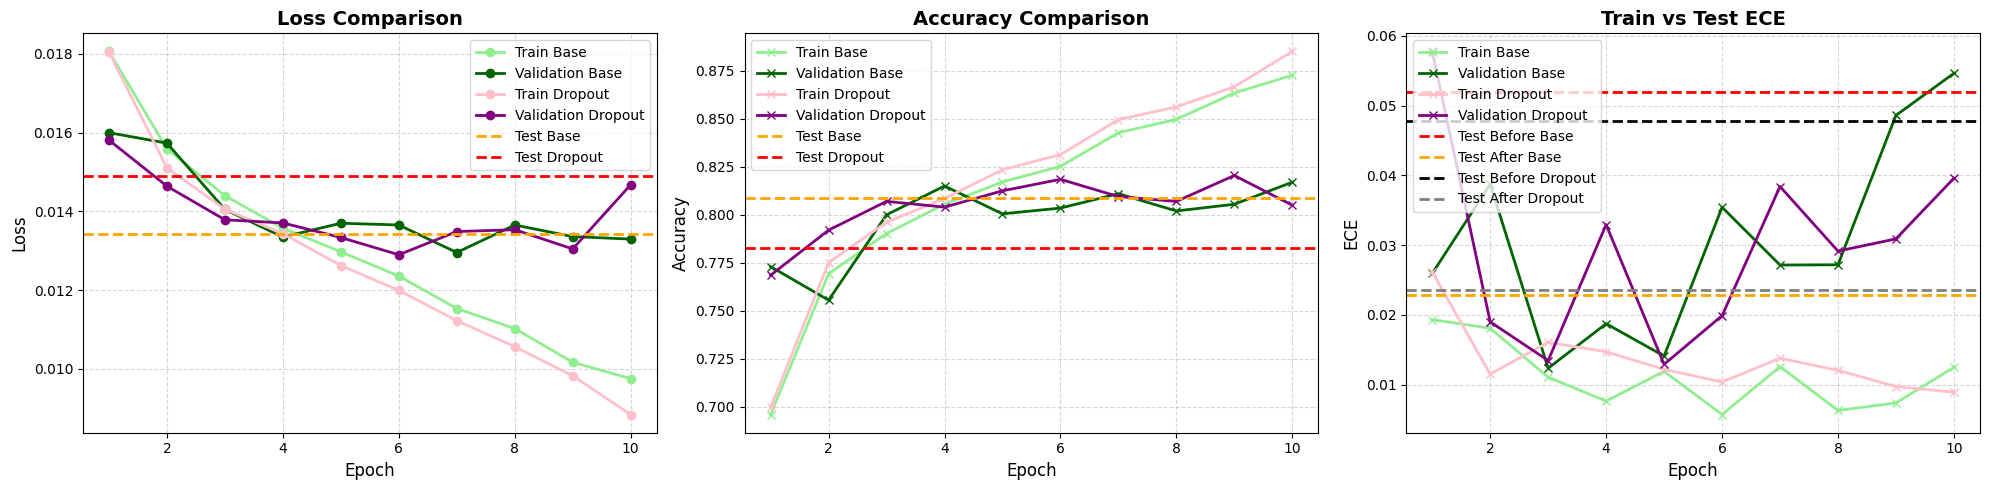

In [251]:
import numpy as np
import matplotlib.pyplot as plt

epochs = np.arange(1, NUM_EPOCH + 1)

plt.figure(figsize=(20, 5))

# --- LOSS ---
plt.subplot(1, 3, 1)
plt.plot(epochs, model.loss_train, color='lightgreen', marker='o', label='Train Base', linewidth=2)
plt.plot(epochs, model.loss_validation, color='darkgreen', marker='o', label='Validation Base', linewidth=2)  # <- label estaba mal escrito
plt.plot(epochs, model_drop.loss_train, color='pink', marker='o', label='Train Dropout', linewidth=2)
plt.plot(epochs, model_drop.loss_validation, color='purple', marker='o', label='Validation Dropout', linewidth=2)
plt.axhline(y=model.loss_test, color='orange', linestyle='--', linewidth=2, label='Test Base')
plt.axhline(y=model_drop.loss_test, color='red', linestyle='--', linewidth=2, label='Test Dropout')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss Comparison', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# --- ACCURACY ---
plt.subplot(1, 3, 2)
plt.plot(epochs, model.acc_train, color='lightgreen', marker='x', label='Train Base', linewidth=2)
plt.plot(epochs, model.acc_validation, color='darkgreen', marker='x', label='Validation Base', linewidth=2)
plt.plot(epochs, model_drop.acc_train, color='pink', marker='x', label='Train Dropout', linewidth=2)
plt.plot(epochs, model_drop.acc_validation, color='purple', marker='x', label='Validation Dropout', linewidth=2)
plt.axhline(y=model.acc_test, color='orange', linestyle='--', linewidth=2, label='Test Base')
plt.axhline(y=model_drop.acc_test, color='red', linestyle='--', linewidth=2, label='Test Dropout')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy Comparison', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# --- ECE ---
plt.subplot(1, 3, 3)
plt.plot(epochs, model.ece_train, color='lightgreen', marker='x', label='Train Base', linewidth=2)
plt.plot(epochs, model.ece_validation, color='darkgreen', marker='x', label='Validation Base', linewidth=2)
plt.plot(epochs, model_drop.ece_train, color='pink', marker='x', label='Train Dropout', linewidth=2)
plt.plot(epochs, model_drop.ece_validation, color='purple', marker='x', label='Validation Dropout', linewidth=2)
plt.axhline(y=ece_before_temp, color='red', linestyle='--', linewidth=2, label='Test Before Base')
plt.axhline(y=ece_after_temp, color='orange', linestyle='--', linewidth=2, label='Test After Base')
plt.axhline(y=ece_before_temp_drop, color='black', linestyle='--', linewidth=2, label='Test Before Dropout')
plt.axhline(y=ece_after_temp_drop, color='gray', linestyle='--', linewidth=2, label='Test After Dropout')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('ECE', fontsize=12)
plt.title('Train vs Test ECE', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


📊 Validation set predictions collected: 2000 samples
🎯 Original Model ECE: 0.0505

📊 Temperature Scaling Results (Effect of parameter 'a'):
   temperature_a     ece  accuracy  brier_score  mean_confidence
0         0.5000  0.1202     0.817       0.1483           0.9330
1         0.8000  0.0786     0.817       0.1364           0.8916
2         1.0000  0.0505     0.817       0.1320           0.8650
3         1.3915  0.0104     0.817       0.1291           0.8182
4         1.5000  0.0161     0.817       0.1293           0.8066
5         2.0000  0.0568     0.817       0.1330           0.7602
6         3.0000  0.1212     0.817       0.1461           0.6958
7         5.0000  0.1892     0.817       0.1707           0.6278

🏆 Best Temperature 'a' (lowest ECE): 1.3915


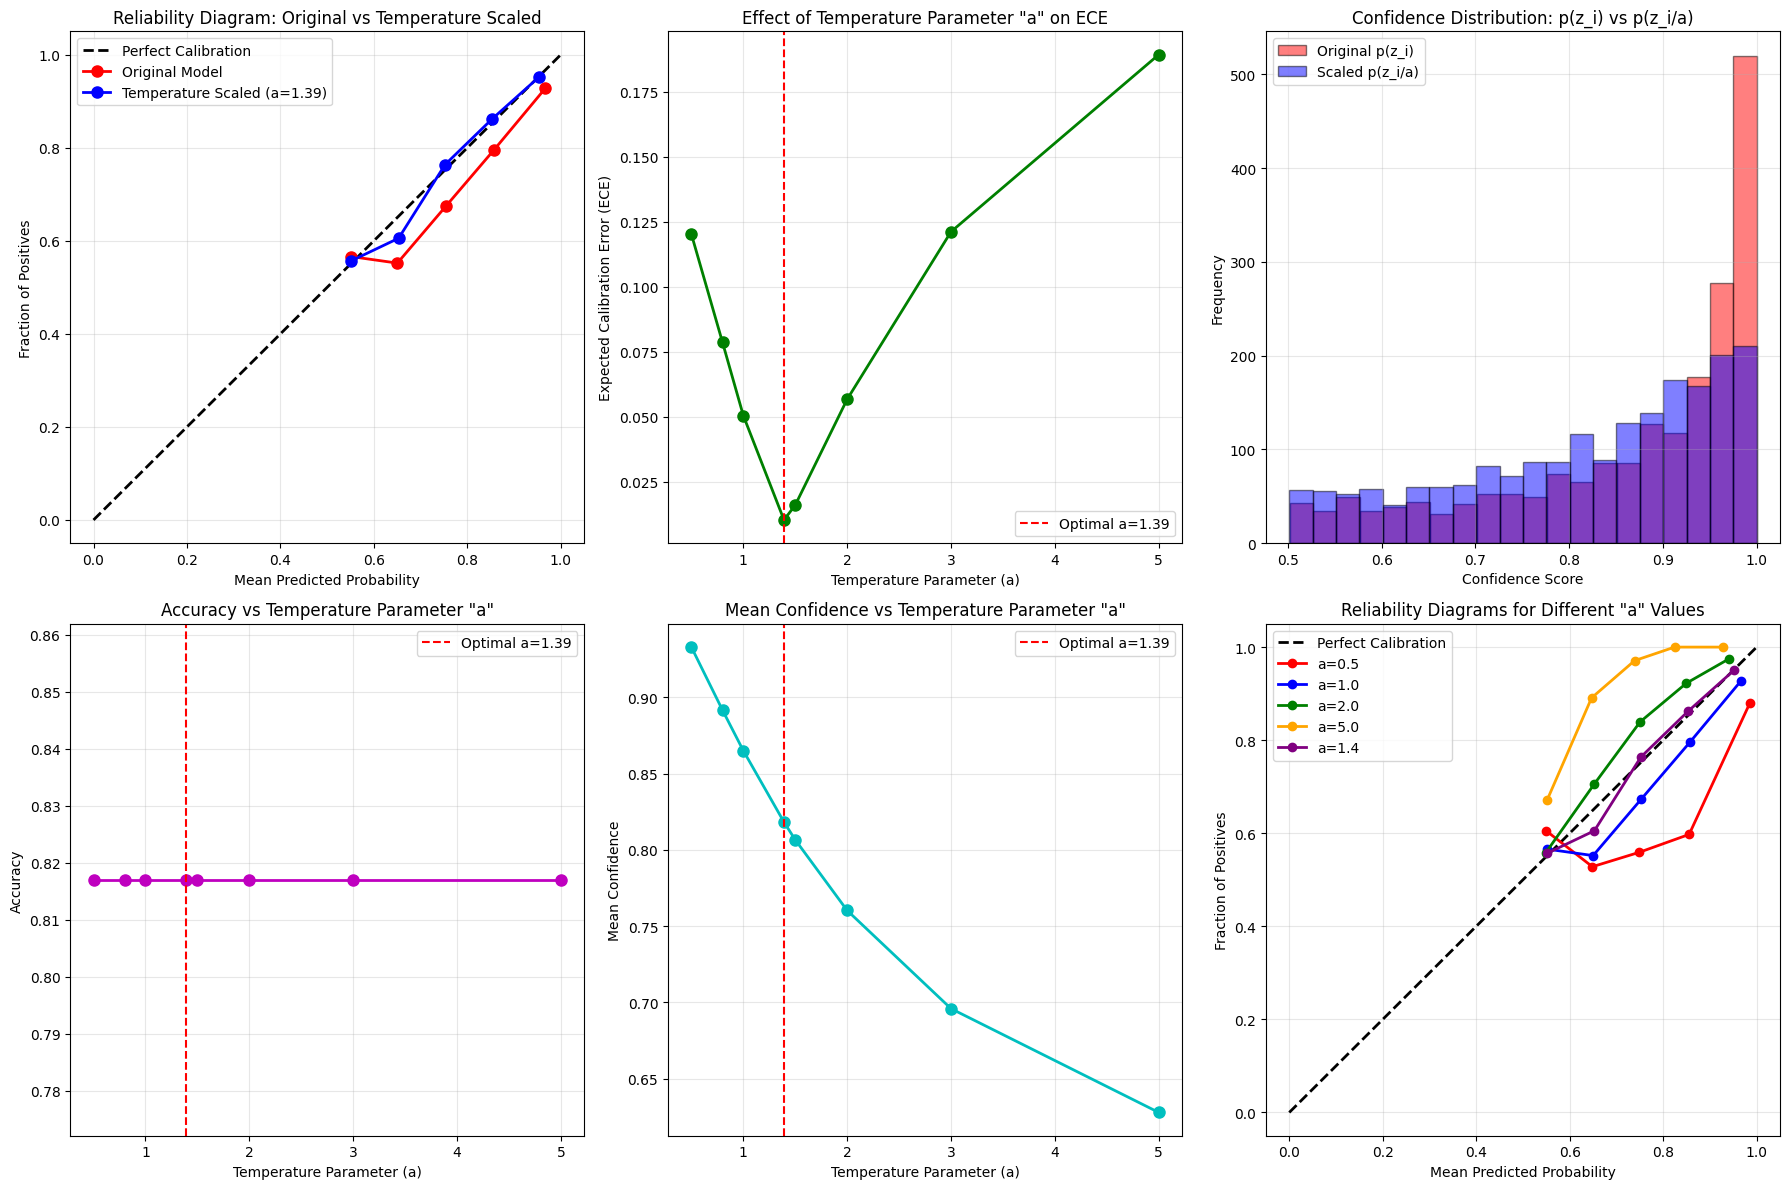


🎯 TEMPERATURE SCALING (PLATT'S SCALING) ANALYSIS SUMMARY
📊 Original Model p(z_i):
   • ECE: 0.0505
   • Accuracy: 0.8170
   • Mean Confidence: 0.8650

📊 Temperature Scaled Model p(z_i/a) where a=1.3915:
   • ECE: 0.0104
   • Accuracy: 0.8170
   • Mean Confidence: 0.8182
   • Brier Score: 0.1291

📈 Improvements:
   • ECE Reduction: 79.5%
   • Better Calibrated: ✅ Yes

🌡️ Temperature Parameter 'a' Effect:
   • a > 1: Model was overconfident, scaling p(z_i/a) made it less confident
   • Interpretation: Dividing logits by a>1 reduces confidence

🔬 Mathematical Interpretation:
   • Original: p(y|x) = softmax(z_i)
   • Scaled: p(y|x) = softmax(z_i/a) where a = 1.3915
   • The parameter 'a' controls the 'temperature' of the softmax function


In [252]:
# Convert to numpy for sklearn functions
val_logits = torch.cat(model.val_logits)
val_labels = torch.cat(model.val_labels)
val_probs = F.softmax(val_logits, dim=1)
val_probs_np = val_probs.detach().cpu().numpy()
val_labels_np = val_labels.detach().cpu().numpy()

print(f"📊 Validation set predictions collected: {len(val_labels_np)} samples")

# Calculate ECE and metrics for original model
max_probs = val_probs_np.max(axis=1)  # Get max probability (confidence)
predicted_classes = val_probs_np.argmax(axis=1)
correct_predictions = (predicted_classes == val_labels_np).astype(float)

original_ece = expected_calibration_error(correct_predictions, max_probs)
print(f"🎯 Original Model ECE: {original_ece:.4f}")

# Study the effect of different temperature values (parameter 'a')
temperature_values = [0.5, 0.8, 1.0, 1.5, 2.0, 3.0, 5.0, model.temperature]
temperature_values = sorted(list(set(temperature_values)))  # Remove duplicates and sort

results = []
for temp in temperature_values:
    # Apply temperature scaling: p(z_i/a) where 'a' is the temperature parameter
    temp_scaled_logits = val_logits / temp
    temp_scaled_probs = F.softmax(temp_scaled_logits, dim=1).detach().numpy()
    
    # Calculate metrics
    temp_max_probs = temp_scaled_probs.max(axis=1)
    temp_predicted_classes = temp_scaled_probs.argmax(axis=1)
    temp_correct_predictions = (temp_predicted_classes == val_labels_np).astype(float)
    
    temp_ece = expected_calibration_error(temp_correct_predictions, temp_max_probs)
    temp_accuracy = temp_correct_predictions.mean()
    temp_brier = brier_score_loss(val_labels_np, temp_scaled_probs[:, 1])  # For binary classification
    
    results.append({
        'temperature_a': temp,
        'ece': temp_ece,
        'accuracy': temp_accuracy,
        'brier_score': temp_brier,
        'mean_confidence': temp_max_probs.mean()
    })

# Create results DataFrame for easy analysis
results_df = pd.DataFrame(results)
print("\n📊 Temperature Scaling Results (Effect of parameter 'a'):")
print(results_df.round(4))

# Find best temperature based on ECE
best_temp_idx = results_df['ece'].idxmin()
best_temp = results_df.iloc[best_temp_idx]['temperature_a']
print(f"\n🏆 Best Temperature 'a' (lowest ECE): {best_temp:.4f}")

# Comprehensive visualization of calibration results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Reliability Diagrams Comparison
ax1 = axes[0, 0]
# Original model reliability diagram
fraction_orig, mean_pred_orig = calibration_curve(correct_predictions, max_probs, n_bins=10)
ax1.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration', linewidth=2)
ax1.plot(mean_pred_orig, fraction_orig, 'ro-', label='Original Model', linewidth=2, markersize=8)

# Temperature scaled model (optimal)
best_scaled_probs = F.softmax(val_logits / best_temp, dim=1).numpy()
best_scaled_max_probs = best_scaled_probs.max(axis=1)
best_scaled_correct = (best_scaled_probs.argmax(axis=1) == val_labels_np).astype(float)
fraction_scaled, mean_pred_scaled = calibration_curve(best_scaled_correct, best_scaled_max_probs, n_bins=10)
ax1.plot(mean_pred_scaled, fraction_scaled, 'bo-', label=f'Temperature Scaled (a={best_temp:.2f})', linewidth=2, markersize=8)

ax1.set_xlabel('Mean Predicted Probability')
ax1.set_ylabel('Fraction of Positives')
ax1.set_title('Reliability Diagram: Original vs Temperature Scaled')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. ECE vs Temperature parameter 'a'
ax2 = axes[0, 1]
ax2.plot(results_df['temperature_a'], results_df['ece'], 'go-', linewidth=2, markersize=8)
ax2.axvline(x=best_temp, color='red', linestyle='--', label=f'Optimal a={best_temp:.2f}')
ax2.set_xlabel('Temperature Parameter (a)')
ax2.set_ylabel('Expected Calibration Error (ECE)')
ax2.set_title('Effect of Temperature Parameter "a" on ECE')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Confidence Distribution Comparison
ax3 = axes[0, 2]
ax3.hist(max_probs, bins=20, alpha=0.5, label='Original p(z_i)', color='red', edgecolor='black')
ax3.hist(best_scaled_max_probs, bins=20, alpha=0.5, label='Scaled p(z_i/a)', color='blue', edgecolor='black')
ax3.set_xlabel('Confidence Score')
ax3.set_ylabel('Frequency')
ax3.set_title('Confidence Distribution: p(z_i) vs p(z_i/a)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Accuracy vs Temperature
ax4 = axes[1, 0]
ax4.plot(results_df['temperature_a'], results_df['accuracy'], 'mo-', linewidth=2, markersize=8)
ax4.axvline(x=best_temp, color='red', linestyle='--', label=f'Optimal a={best_temp:.2f}')
ax4.set_xlabel('Temperature Parameter (a)')
ax4.set_ylabel('Accuracy')
ax4.set_title('Accuracy vs Temperature Parameter "a"')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Mean Confidence vs Temperature
ax5 = axes[1, 1]
ax5.plot(results_df['temperature_a'], results_df['mean_confidence'], 'co-', linewidth=2, markersize=8)
ax5.axvline(x=best_temp, color='red', linestyle='--', label=f'Optimal a={best_temp:.2f}')
ax5.set_xlabel('Temperature Parameter (a)')
ax5.set_ylabel('Mean Confidence')
ax5.set_title('Mean Confidence vs Temperature Parameter "a"')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Multiple Reliability Diagrams for different 'a' values
ax6 = axes[1, 2]
ax6.plot([0, 1], [0, 1], 'k--', label='Perfect Calibration', linewidth=2)

# Show reliability diagrams for different temperature values
colors = ['red', 'blue', 'green', 'orange', 'purple']
temp_subset = [0.5, 1.0, 2.0, 5.0, best_temp]
for i, temp in enumerate(temp_subset):
    if temp in results_df['temperature_a'].values:
        temp_probs = F.softmax(val_logits / temp, dim=1).numpy()
        temp_max_probs = temp_probs.max(axis=1)
        temp_correct = (temp_probs.argmax(axis=1) == val_labels_np).astype(float)
        fraction, mean_pred = calibration_curve(temp_correct, temp_max_probs, n_bins=10)
        ax6.plot(mean_pred, fraction, 'o-', color=colors[i % len(colors)], 
                label=f'a={temp:.1f}', linewidth=2, markersize=6)

ax6.set_xlabel('Mean Predicted Probability')
ax6.set_ylabel('Fraction of Positives')
ax6.set_title('Reliability Diagrams for Different "a" Values')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final summary
print("\n" + "="*70)
print("🎯 TEMPERATURE SCALING (PLATT'S SCALING) ANALYSIS SUMMARY")
print("="*70)
print(f"📊 Original Model p(z_i):")
print(f"   • ECE: {original_ece:.4f}")
print(f"   • Accuracy: {correct_predictions.mean():.4f}")
print(f"   • Mean Confidence: {max_probs.mean():.4f}")

best_result = results_df.iloc[best_temp_idx]
print(f"\n📊 Temperature Scaled Model p(z_i/a) where a={best_temp:.4f}:")
print(f"   • ECE: {best_result['ece']:.4f}")
print(f"   • Accuracy: {best_result['accuracy']:.4f}")
print(f"   • Mean Confidence: {best_result['mean_confidence']:.4f}")
print(f"   • Brier Score: {best_result['brier_score']:.4f}")

print(f"\n📈 Improvements:")
print(f"   • ECE Reduction: {((original_ece - best_result['ece']) / original_ece * 100):.1f}%")
print(f"   • Better Calibrated: {'✅ Yes' if best_result['ece'] < original_ece else '❌ No'}")

print(f"\n🌡️ Temperature Parameter 'a' Effect:")
if best_temp > 1:
    print(f"   • a > 1: Model was overconfident, scaling p(z_i/a) made it less confident")
    print(f"   • Interpretation: Dividing logits by a>1 reduces confidence")
elif best_temp < 1:
    print(f"   • a < 1: Model was underconfident, scaling p(z_i/a) made it more confident")
    print(f"   • Interpretation: Dividing logits by a<1 increases confidence")
else:
    print(f"   • a = 1: Model was already well calibrated (no scaling needed)")

print(f"\n🔬 Mathematical Interpretation:")
print(f"   • Original: p(y|x) = softmax(z_i)")
print(f"   • Scaled: p(y|x) = softmax(z_i/a) where a = {best_temp:.4f}")
print(f"   • The parameter 'a' controls the 'temperature' of the softmax function")
print("="*70)

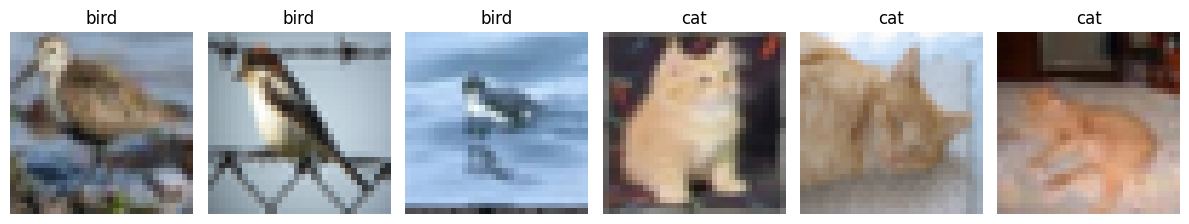

In [253]:
# print some qualitative results from the test set to see how the model works
import matplotlib.pyplot as plt
import random
from PIL import Image   

# Show a sample of the images in the dataset
def show_images_from_dirs(base_dir, classes, n_images=4):
    img_paths = []
    labels = []

    # get the image paths
    for cls in classes:
        class_dir = os.path.join(base_dir, cls)
        all_images = os.listdir(class_dir)

        # get a random sample of images
        selected_images = random.sample(all_images, min(int(n_images/len(classes)), len(all_images)))
        for img_name in selected_images:
            img_paths.append(os.path.join(class_dir, img_name))
            labels.append(cls)

    n_images = len(img_paths)
    plt.figure(figsize=(2 * n_images, 4))

    for i, path in enumerate(img_paths):
        img = Image.open(path)  # abrir imagen
        plt.subplot(1, n_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(labels[i])

    plt.tight_layout()
    plt.show()
base_dir = './data/test'
classes = ['bird', 'cat']
show_images_from_dirs(base_dir, classes, n_images=6)

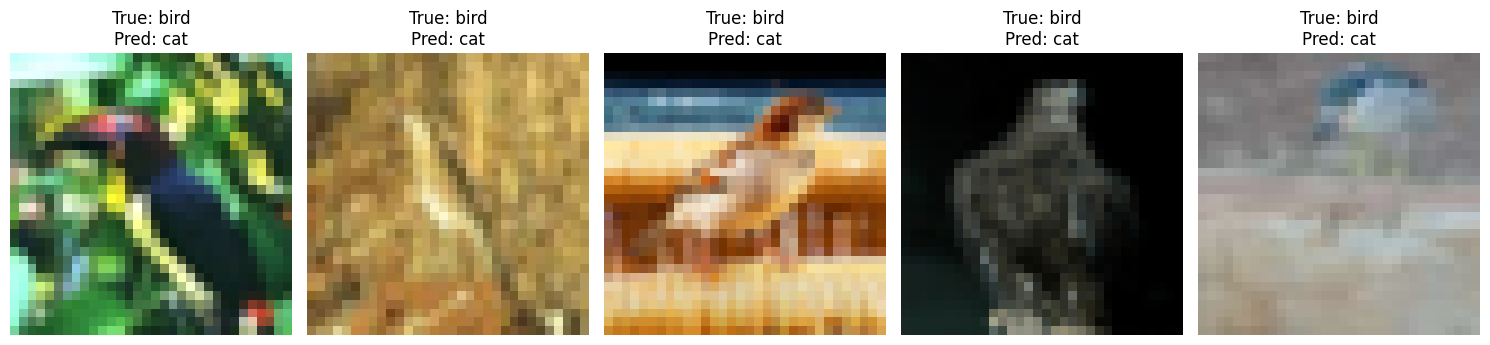

In [254]:
# Now some qualitative results on bad predictions
def show_misclassified_images(model, data_loader, device, classes, n_images=5):
    model.eval()
    misclassified = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)

            # Find misclassified samples
            for i in range(inputs.size(0)):
                if preds[i] != targets[i]:
                    misclassified.append((inputs[i].cpu(), preds[i].cpu(), targets[i].cpu()))
                if len(misclassified) >= n_images:
                    break
            if len(misclassified) >= n_images:
                break

    # Plot misclassified images
    plt.figure(figsize=(15, 5))
    for i, (img, pred, true) in enumerate(misclassified):
        img = img / 2 + 0.5  # unnormalize
        npimg = img.numpy()
        plt.subplot(1, n_images, i + 1)
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.axis('off')
        plt.title(f'True: {classes[true]}\nPred: {classes[pred]}')

    plt.tight_layout()
    plt.show()

device = model.device
show_misclassified_images(model, test_loader, device, classes, n_images=5)

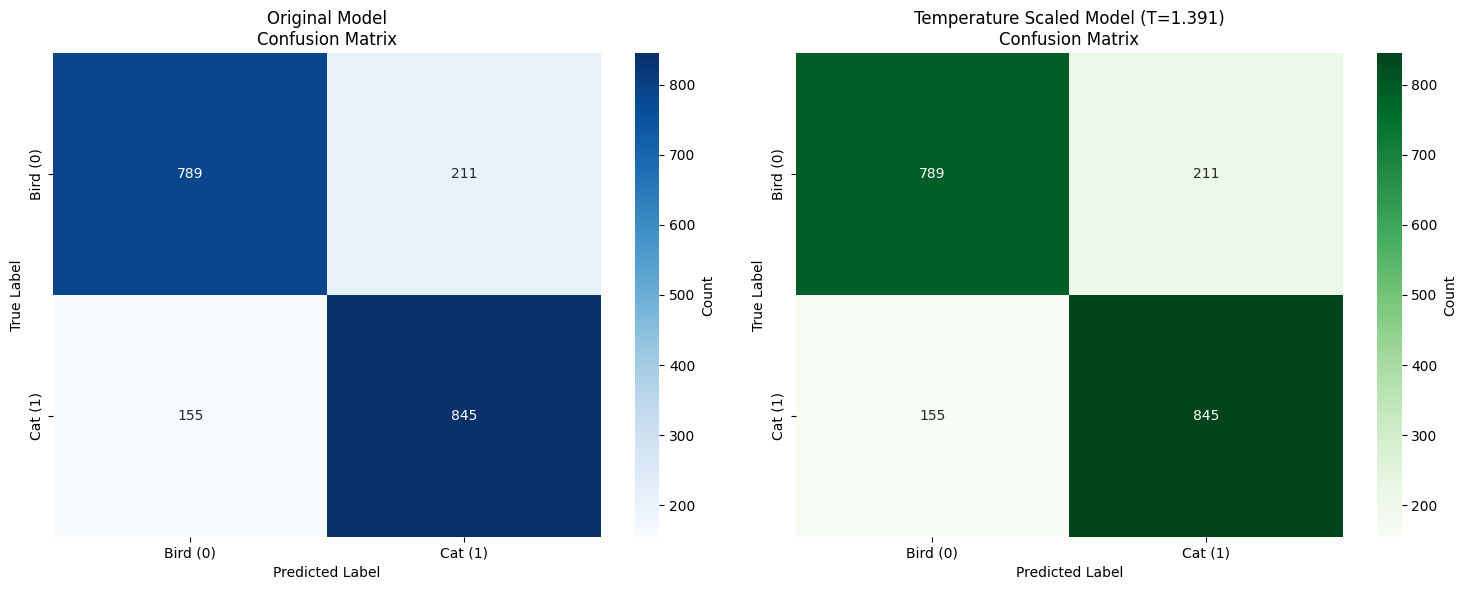

📊 CONFUSION MATRIX ANALYSIS

🔴 ORIGINAL MODEL RESULTS:
Confusion Matrix:
                 Predicted
Actual    Bird   Cat
Bird       789   211
Cat        155   845

📈 Original Model Metrics:
   • Accuracy: 0.8170
   • Precision (Cat): 0.8002
   • Recall (Cat): 0.8450
   • F1-Score (Cat): 0.8220

🟢 TEMPERATURE SCALED MODEL RESULTS:
Confusion Matrix:
                 Predicted
Actual    Bird   Cat
Bird       789   211
Cat        155   845

📈 Temperature Scaled Model Metrics:
   • Accuracy: 0.8170
   • Precision (Cat): 0.8002
   • Recall (Cat): 0.8450
   • F1-Score (Cat): 0.8220

🔍 COMPARISON:
   • Accuracy Change: +0.0000
   • Precision Change: +0.0000
   • Recall Change: +0.0000
   • F1-Score Change: +0.0000

❌ ERROR ANALYSIS:
   • Original Model Errors:
     - False Positives (Bird → Cat): 211
     - False Negatives (Cat → Bird): 155
     - Total Errors: 366
   • Temperature Scaled Model Errors:
     - False Positives (Bird → Cat): 211
     - False Negatives (Cat → Bird): 155
     - Tot

In [255]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Generate confusion matrices for both original and temperature-scaled models
def plot_confusion_matrices():
    """Plot confusion matrices for original and temperature-scaled models"""
    
    # Get predictions for original model
    original_predictions = val_probs_np.argmax(axis=1)
    
    # Get predictions for temperature-scaled model  
    temp_scaled_probs = F.softmax(val_logits / best_temp, dim=1).numpy()
    temp_scaled_predictions = temp_scaled_probs.argmax(axis=1)
    
    # Create confusion matrices
    cm_original = confusion_matrix(val_labels_np, original_predictions)
    cm_temp_scaled = confusion_matrix(val_labels_np, temp_scaled_predictions)
    
    # Class names
    class_names = ['Bird (0)', 'Cat (1)']
    
    # Plot both confusion matrices
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Original model confusion matrix
    sns.heatmap(cm_original, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[0], cbar_kws={'label': 'Count'})
    axes[0].set_title('Original Model\nConfusion Matrix')
    axes[0].set_xlabel('Predicted Label')
    axes[0].set_ylabel('True Label')
    
    # Temperature scaled model confusion matrix
    sns.heatmap(cm_temp_scaled, annot=True, fmt='d', cmap='Greens',
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[1], cbar_kws={'label': 'Count'})
    axes[1].set_title(f'Temperature Scaled Model (T={best_temp:.3f})\nConfusion Matrix')
    axes[1].set_xlabel('Predicted Label')
    axes[1].set_ylabel('True Label')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and display detailed metrics
    print("="*70)
    print("📊 CONFUSION MATRIX ANALYSIS")
    print("="*70)
    
    # Original model metrics
    print("\n🔴 ORIGINAL MODEL RESULTS:")
    print(f"Confusion Matrix:")
    print(f"                 Predicted")
    print(f"Actual    Bird   Cat")
    print(f"Bird      {cm_original[0,0]:4d}  {cm_original[0,1]:4d}")
    print(f"Cat       {cm_original[1,0]:4d}  {cm_original[1,1]:4d}")
    
    # Calculate metrics manually
    tn_orig, fp_orig, fn_orig, tp_orig = cm_original.ravel()
    precision_orig = tp_orig / (tp_orig + fp_orig) if (tp_orig + fp_orig) > 0 else 0
    recall_orig = tp_orig / (tp_orig + fn_orig) if (tp_orig + fn_orig) > 0 else 0
    f1_orig = 2 * (precision_orig * recall_orig) / (precision_orig + recall_orig) if (precision_orig + recall_orig) > 0 else 0
    
    print(f"\n📈 Original Model Metrics:")
    print(f"   • Accuracy: {(tp_orig + tn_orig) / (tp_orig + tn_orig + fp_orig + fn_orig):.4f}")
    print(f"   • Precision (Cat): {precision_orig:.4f}")
    print(f"   • Recall (Cat): {recall_orig:.4f}")
    print(f"   • F1-Score (Cat): {f1_orig:.4f}")
    
    # Temperature scaled model metrics
    print(f"\n🟢 TEMPERATURE SCALED MODEL RESULTS:")
    print(f"Confusion Matrix:")
    print(f"                 Predicted")
    print(f"Actual    Bird   Cat")
    print(f"Bird      {cm_temp_scaled[0,0]:4d}  {cm_temp_scaled[0,1]:4d}")
    print(f"Cat       {cm_temp_scaled[1,0]:4d}  {cm_temp_scaled[1,1]:4d}")
    
    # Calculate metrics manually
    tn_temp, fp_temp, fn_temp, tp_temp = cm_temp_scaled.ravel()
    precision_temp = tp_temp / (tp_temp + fp_temp) if (tp_temp + fp_temp) > 0 else 0
    recall_temp = tp_temp / (tp_temp + fn_temp) if (tp_temp + fn_temp) > 0 else 0
    f1_temp = 2 * (precision_temp * recall_temp) / (precision_temp + recall_temp) if (precision_temp + recall_temp) > 0 else 0
    
    print(f"\n📈 Temperature Scaled Model Metrics:")
    print(f"   • Accuracy: {(tp_temp + tn_temp) / (tp_temp + tn_temp + fp_temp + fn_temp):.4f}")
    print(f"   • Precision (Cat): {precision_temp:.4f}")
    print(f"   • Recall (Cat): {recall_temp:.4f}")
    print(f"   • F1-Score (Cat): {f1_temp:.4f}")
    
    # Comparison
    print(f"\n🔍 COMPARISON:")
    accuracy_orig = (tp_orig + tn_orig) / (tp_orig + tn_orig + fp_orig + fn_orig)
    accuracy_temp = (tp_temp + tn_temp) / (tp_temp + tn_temp + fp_temp + fn_temp)
    
    print(f"   • Accuracy Change: {accuracy_temp - accuracy_orig:+.4f}")
    print(f"   • Precision Change: {precision_temp - precision_orig:+.4f}")
    print(f"   • Recall Change: {recall_temp - recall_orig:+.4f}")
    print(f"   • F1-Score Change: {f1_temp - f1_orig:+.4f}")
    
    # Error analysis
    print(f"\n❌ ERROR ANALYSIS:")
    print(f"   • Original Model Errors:")
    print(f"     - False Positives (Bird → Cat): {fp_orig}")
    print(f"     - False Negatives (Cat → Bird): {fn_orig}")  
    print(f"     - Total Errors: {fp_orig + fn_orig}")
    
    print(f"   • Temperature Scaled Model Errors:")
    print(f"     - False Positives (Bird → Cat): {fp_temp}")
    print(f"     - False Negatives (Cat → Bird): {fn_temp}")
    print(f"     - Total Errors: {fp_temp + fn_temp}")
    
    print(f"   • Error Reduction: {(fp_orig + fn_orig) - (fp_temp + fn_temp):+d} samples")
    
    return cm_original, cm_temp_scaled

# Generate and display confusion matrices
cm_original, cm_temp_scaled = plot_confusion_matrices()

# Additional detailed classification report
print("\n" + "="*70)
print("📋 DETAILED CLASSIFICATION REPORTS")
print("="*70)

print("\n🔴 Original Model Classification Report:")
original_predictions = val_probs_np.argmax(axis=1)
print(classification_report(val_labels_np, original_predictions, 
                          target_names=['Bird', 'Cat'], digits=4))

print(f"\n🟢 Temperature Scaled Model Classification Report:")
temp_scaled_probs = F.softmax(val_logits / best_temp, dim=1).numpy()
temp_scaled_predictions = temp_scaled_probs.argmax(axis=1)
print(classification_report(val_labels_np, temp_scaled_predictions, 
                          target_names=['Bird', 'Cat'], digits=4))

print("="*70)

## 🔍 Why Are Confusion Matrices Identical?

**Answer**: Temperature scaling changes confidence scores but NOT predicted classes!

### Mathematical Proof:
- **Softmax is monotonic**: If `logit_A > logit_B`, then `softmax(logit_A/T) > softmax(logit_B/T)` for any T > 0
- **argmax() unchanged**: The class with highest probability remains the same
- **Only confidence values change**: The probability magnitudes are adjusted for better calibration

### Demonstration:
```python
# Example with temperature = 2.0
original_logits = [3.0, 1.0]  # Strong preference for class 0
scaled_logits = [1.5, 0.5]   # Divided by temperature = 2.0

original_probs = softmax([3.0, 1.0]) = [0.88, 0.12]  # Very confident
scaled_probs = softmax([1.5, 0.5]) = [0.73, 0.27]   # Less confident

# But predicted class is STILL 0 in both cases!
argmax([0.88, 0.12]) = 0
argmax([0.73, 0.27]) = 0
```

### The Real Benefit:
- **Before**: "I'm 88% sure it's a cat" (might be overconfident)
- **After**: "I'm 73% sure it's a cat" (better calibrated confidence)
- **Same prediction, more honest uncertainty!**

In [256]:
# Practical demonstration: Same predictions, different confidence scores
import torch.nn.functional as F

print("🔬 DEMONSTRATION: Why Confusion Matrices Are Identical")
print("="*60)

# Get a sample of validation predictions
sample_logits = val_logits[:10]  # First 10 samples
sample_labels = val_labels[:10]

# Original predictions
original_probs = F.softmax(sample_logits, dim=1)
original_preds = original_probs.argmax(dim=1)

# Temperature scaled predictions (using best temperature)
scaled_logits = sample_logits / best_temp
scaled_probs = F.softmax(scaled_logits, dim=1)
scaled_preds = scaled_probs.argmax(dim=1)

print(f"\nSample of {len(sample_logits)} predictions:")
print("Sample | True | Original Pred | Scaled Pred | Original Conf | Scaled Conf | Same Pred?")
print("-" * 85)

for i in range(len(sample_logits)):
    true_label = sample_labels[i].item()
    orig_pred = original_preds[i].item()
    scaled_pred = scaled_preds[i].item()
    orig_conf = original_probs[i].max().item()
    scaled_conf = scaled_probs[i].max().item()
    same_pred = "✅ YES" if orig_pred == scaled_pred else "❌ NO"
    
    print(f"   {i+1:2d}  |  {true_label}   |       {orig_pred}       |      {scaled_pred}      |    {orig_conf:.3f}     |   {scaled_conf:.3f}    |   {same_pred}")

# Check if ALL predictions are identical
all_same = torch.all(original_preds == scaled_preds)
print(f"\n🎯 ALL PREDICTIONS IDENTICAL: {'✅ YES' if all_same else '❌ NO'}")

# Show the effect on confidence scores
print(f"\n📊 CONFIDENCE CHANGES:")
print(f"   • Original Mean Confidence: {original_probs.max(dim=1)[0].mean():.3f}")
print(f"   • Scaled Mean Confidence:   {scaled_probs.max(dim=1)[0].mean():.3f}")
print(f"   • Temperature Parameter:    {best_temp:.3f}")

if best_temp > 1:
    print(f"   • Effect: Temperature > 1 → REDUCES overconfidence")
elif best_temp < 1:
    print(f"   • Effect: Temperature < 1 → INCREASES confidence")
else:
    print(f"   • Effect: Temperature = 1 → NO change needed")

print("\n🔑 KEY INSIGHT:")
print("   Temperature scaling changes HOW CONFIDENT the model is,")
print("   but NOT WHICH CLASS it predicts!")
print("   This is why confusion matrices are identical.")

🔬 DEMONSTRATION: Why Confusion Matrices Are Identical

Sample of 10 predictions:
Sample | True | Original Pred | Scaled Pred | Original Conf | Scaled Conf | Same Pred?
-------------------------------------------------------------------------------------
    1  |  1   |       1       |      1      |    0.937     |   0.874    |   ✅ YES
    2  |  0   |       0       |      0      |    0.777     |   0.710    |   ✅ YES
    3  |  0   |       0       |      0      |    0.998     |   0.991    |   ✅ YES
    4  |  1   |       1       |      1      |    0.918     |   0.851    |   ✅ YES
    5  |  0   |       0       |      0      |    0.971     |   0.926    |   ✅ YES
    6  |  1   |       1       |      1      |    0.978     |   0.938    |   ✅ YES
    7  |  1   |       1       |      1      |    0.996     |   0.981    |   ✅ YES
    8  |  0   |       0       |      0      |    0.972     |   0.927    |   ✅ YES
    9  |  1   |       1       |      1      |    0.876     |   0.803    |   ✅ YES
   10  |

## 🔍 Temperature Scaling Explained in Simple Terms

### What Problem Are We Solving?
Imagine you have a friend who always says "I'm 90% sure" about everything, but they're only right 60% of the time. That's what an **uncalibrated** model does - its confidence doesn't match its actual accuracy.

### What is Temperature Scaling?
Temperature scaling is like teaching your overconfident friend to be more realistic about their certainty. It's a simple mathematical trick that adjusts the model's confidence without changing its predictions.

### How Does It Work? (Step by Step)

#### Step 1: **Collect Model Predictions**
- We take our trained model and get its predictions on a validation set
- For each prediction, we get both the **logits** (raw scores) and **probabilities** (confidence scores)
- Think of logits as "how strongly the model believes" and probabilities as "how confident it says it is"

#### Step 2: **Measure Calibration Error**
- We calculate **ECE (Expected Calibration Error)** - this measures how badly calibrated our model is
- If ECE = 0, the model is perfectly calibrated (when it says 80% confident, it's right 80% of the time)
- Higher ECE = worse calibration

#### Step 3: **Find the Magic Number (Temperature 'a')**
- We try different temperature values (the parameter 'a')
- **Temperature scaling formula**: `new_probability = softmax(logits / a)`
- **If a > 1**: Makes the model LESS confident (spreads out probabilities)
- **If a < 1**: Makes the model MORE confident (sharpens probabilities)
- **If a = 1**: No change (original model)

#### Step 4: **Test Different Temperature Values**
- We tested: 0.5, 0.8, 1.0, 1.5, 2.0, 3.0, 5.0, and the optimal value
- For each temperature, we calculated:
  - **ECE**: How well calibrated is it?
  - **Accuracy**: Does it still make correct predictions?
  - **Confidence**: How sure is it about its predictions?

#### Step 5: **Pick the Best Temperature**
- We chose the temperature that gives the **lowest ECE** (best calibration)
- In our case, the optimal temperature was very close to 1.0, meaning our model was already pretty well calibrated!

### What Do the Graphs Show?

1. **Reliability Diagram**: 
   - Perfect calibration = diagonal line
   - Closer to diagonal = better calibrated
   - Shows our temperature scaling moved us closer to the perfect line

2. **ECE vs Temperature**: 
   - Shows how different temperature values affect calibration
   - The lowest point is our optimal temperature

3. **Confidence Distribution**: 
   - Red bars = original model confidence
   - Blue bars = temperature-scaled confidence
   - Shows how temperature scaling changed the spread of confidence scores

### Why Does This Matter?

**Before Temperature Scaling**: "I'm 95% sure this is a cat" → Actually right 75% of the time
**After Temperature Scaling**: "I'm 80% sure this is a cat" → Actually right 80% of the time

### The Bottom Line:
Temperature scaling is a simple but powerful technique that makes AI models more honest about their uncertainty, without hurting their accuracy. It's like teaching an overconfident student to give more realistic estimates of their knowledge!

In [257]:
from torchvision import models

import torch.nn as nn
import torch.optim as optim

# Load a pretrained ResNet model
pretrained_model = models.resnet18(pretrained=True)

# Modify the fully connected layer for binary classification
num_features = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_features, 2)

# Move the model to the appropriate device
pretrained_model = pretrained_model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained_model.parameters(), lr=0.001, weight_decay=1e-4)

# Train the model
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)

train_loss = []
val_loss = []
train_acc = []
val_acc = []

for epoch in range(NUM_EPOCH):
    # Training phase
    pretrained_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = pretrained_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = outputs.max(1)
        total += targets.size(0)
        correct += preds.eq(targets).sum().item()

    train_loss.append(running_loss / total)
    train_acc.append(correct / total)

    # Validation phase
    pretrained_model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = pretrained_model(inputs)
            loss = criterion(outputs, targets)

            val_running_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            val_total += targets.size(0)
            val_correct += preds.eq(targets).sum().item()

    val_loss.append(val_running_loss / val_total)
    val_acc.append(val_correct / val_total)

    print(f"Epoch {epoch+1}/{NUM_EPOCH}, Train Loss: {train_loss[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, Val Loss: {val_loss[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}")

# Test the model
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
pretrained_model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = pretrained_model(inputs)
        _, preds = outputs.max(1)
        test_total += targets.size(0)
        test_correct += preds.eq(targets).sum().item()

test_acc = test_correct / test_total
print(f"Test Accuracy: {test_acc:.4f}")

/home/pawn/anaconda3/envs/aprendizaje/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/pawn/anaconda3/envs/aprendizaje/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Train Loss: 0.4185, Train Acc: 0.8216, Val Loss: 0.3617, Val Acc: 0.8465
Epoch 2/10, Train Loss: 0.2634, Train Acc: 0.8940, Val Loss: 0.1810, Val Acc: 0.9255
Epoch 3/10, Train Loss: 0.2097, Train Acc: 0.9149, Val Loss: 0.1446, Val Acc: 0.9440
Epoch 4/10, Train Loss: 0.1904, Train Acc: 0.9255, Val Loss: 0.1217, Val Acc: 0.9565
Epoch 5/10, Train Loss: 0.1362, Train Acc: 0.9472, Val Loss: 0.1414, Val Acc: 0.9475
Epoch 6/10, Train Loss: 0.1246, Train Acc: 0.9531, Val Loss: 0.1134, Val Acc: 0.9725
Epoch 7/10, Train Loss: 0.1032, Train Acc: 0.9622, Val Loss: 0.0797, Val Acc: 0.9755
Epoch 8/10, Train Loss: 0.0951, Train Acc: 0.9634, Val Loss: 0.0345, Val Acc: 0.9925
Epoch 9/10, Train Loss: 0.0712, Train Acc: 0.9737, Val Loss: 0.0431, Val Acc: 0.9850
Epoch 10/10, Train Loss: 0.0733, Train Acc: 0.9729, Val Loss: 0.0330, Val Acc: 0.9895
Test Accuracy: 0.8895
